In [2]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["MKL_THREADING_LAYER"] = "GNU"
#os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["THEANO_FLAGS"]  = "device=cuda%d"%(1)
import numpy as np
# import theano as th
# import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras

Using TensorFlow backend.


## Data Setup

In [3]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'), encoding="latin1")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

('8PSK', 16)


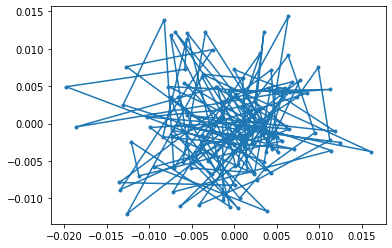

In [4]:
idx= 18000
print(lbl[idx])
plt.plot(X[idx,0,:], X[idx,1,:],'.-')

In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [6]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [7]:
# Set up some params 
nb_epoch = 50     # number of epochs to train on
batch_size = 1024  # training batch size

## Build the NN model

In [8]:
from keras.layers.convolutional import Conv2D
print(in_shp)
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
# model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(64, (2, 8), padding='valid', data_format="channels_last", activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Conv2D(32, (1, 32), padding='valid', data_format="channels_last", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
# model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

[2, 128]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 121, 64)        1088      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 121, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 90, 32)         65568     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 90, 32)         0         
________________________________________________________

## Evaluate the non-pruned model

In [20]:
# we re-load the best weights once training is finished
filepath = './model/RF-CNN-full.h5'
model.load_weights(filepath)

In [21]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

1.2573120907956903


In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

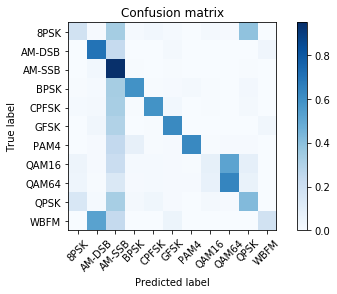

In [23]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.09423604757548033
Overall Accuracy:  0.09264305177111716
Overall Accuracy:  0.09949348769898697
Overall Accuracy:  0.10627932154456875
Overall Accuracy:  0.1462169553327256
Overall Accuracy:  0.22072152123689354
Overall Accuracy:  0.3240859819952232
Overall Accuracy:  0.4703079178885631
Overall Accuracy:  0.588909426987061
Overall Accuracy:  0.6594702467343977
Overall Accuracy:  0.7111313868613138
Overall Accuracy:  0.7170119956379498
Overall Accuracy:  0.737885462555066
Overall Accuracy:  0.734115523465704
Overall Accuracy:  0.7341749323715059
Overall Accuracy:  0.7477231329690346
Overall Accuracy:  0.7238819482165489
Overall Accuracy:  0.7403579996309282
Overall Accuracy:  0.7382805429864253
Overall Accuracy:  0.7337533753375337


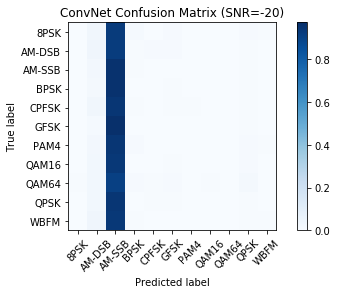

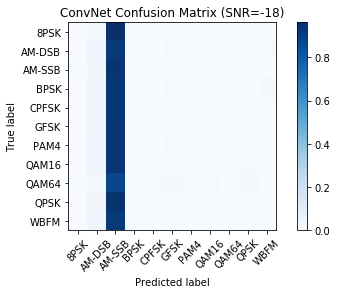

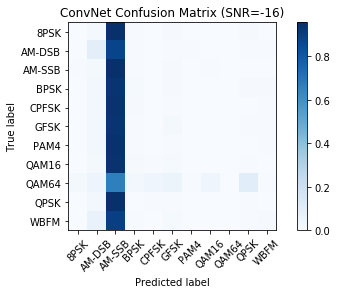

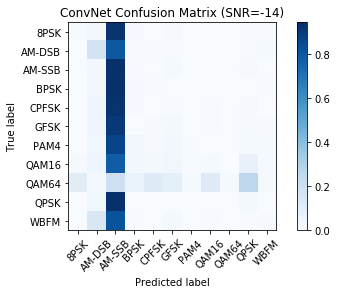

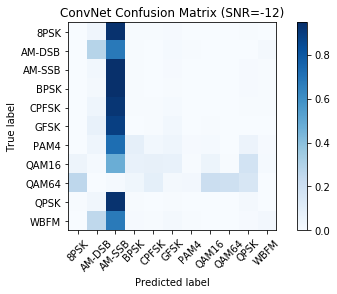

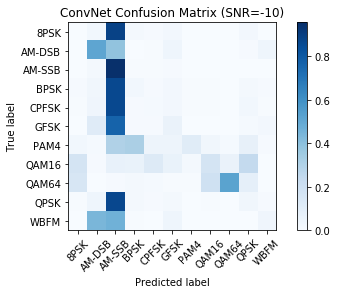

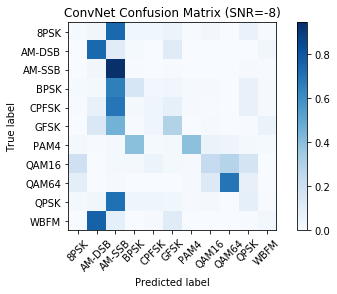

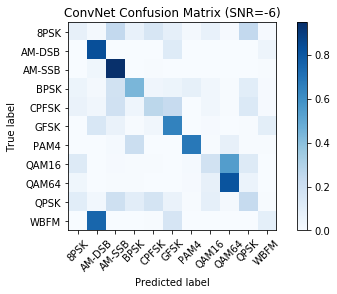

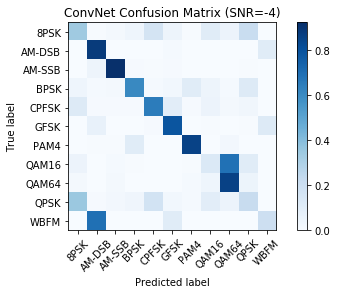

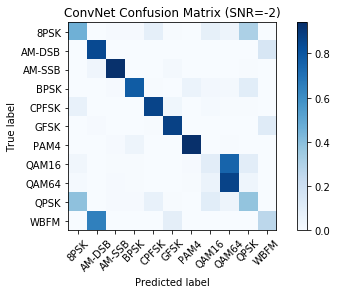

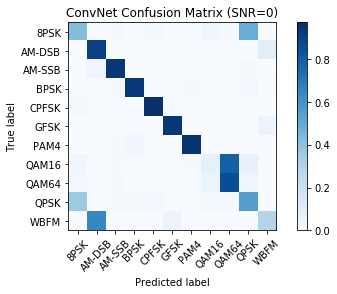

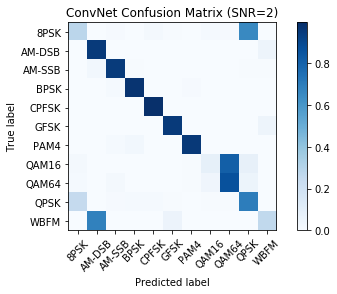

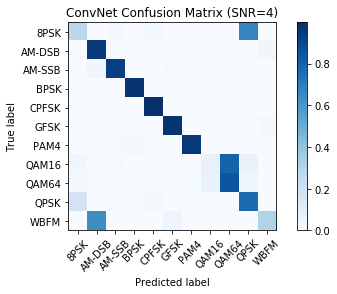

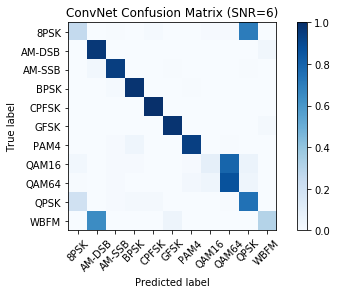

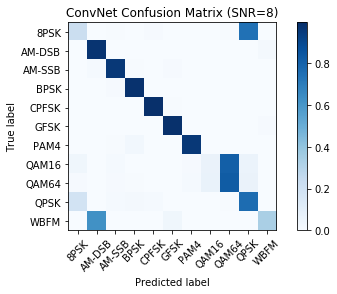

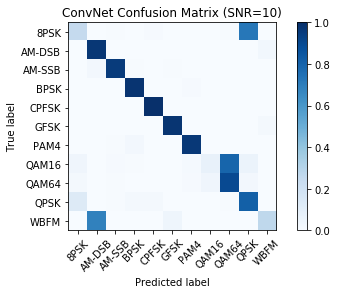

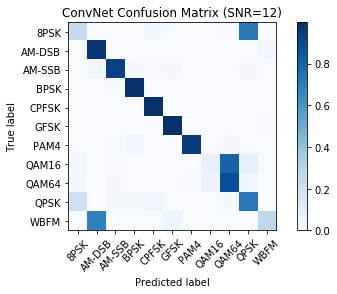

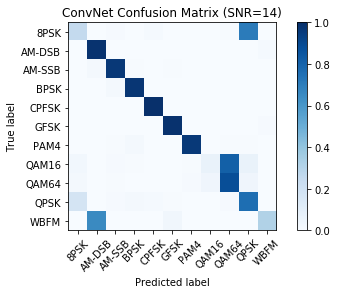

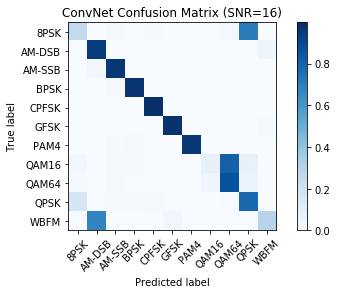

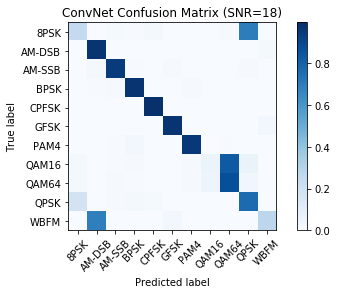

In [24]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

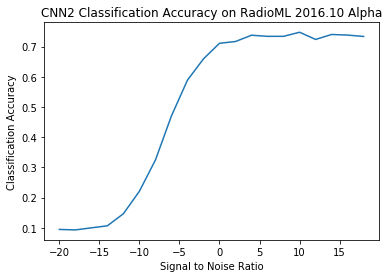

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

## Evaluate the pruned-models

In [17]:
import tensorflow as tf

In [21]:
# Load the pruned model
with open('model/RF-CNN-pruned-0.9.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
#load weights into new model
model.load_weights("./model/RF-CNN-pruned-0.9.h5","r")
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [22]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

1.3530940281001005


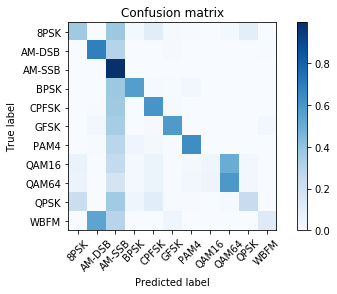

In [24]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.09313815187557183
Overall Accuracy:  0.09118982742960945
Overall Accuracy:  0.0917149059334298
Overall Accuracy:  0.09130277878022375
Overall Accuracy:  0.12215132178669097
Overall Accuracy:  0.18322374266927316
Overall Accuracy:  0.2711739849347786
Overall Accuracy:  0.39919354838709675
Overall Accuracy:  0.5386321626617375
Overall Accuracy:  0.6456821480406386
Overall Accuracy:  0.7023722627737227
Overall Accuracy:  0.722464558342421
Overall Accuracy:  0.7415565345080763
Overall Accuracy:  0.7425992779783394
Overall Accuracy:  0.7354373309287646
Overall Accuracy:  0.7482695810564663
Overall Accuracy:  0.7322107550244432
Overall Accuracy:  0.7374054253552316
Overall Accuracy:  0.7283257918552036
Overall Accuracy:  0.74005400540054


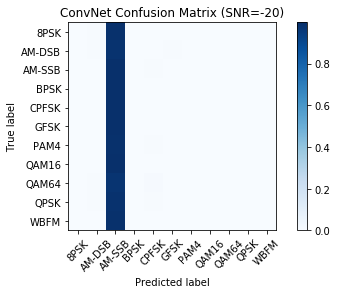

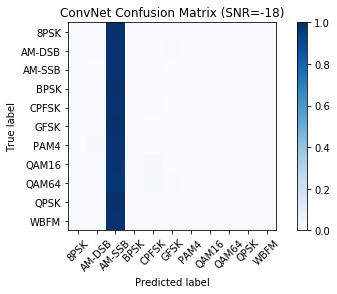

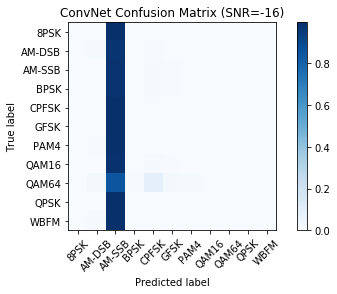

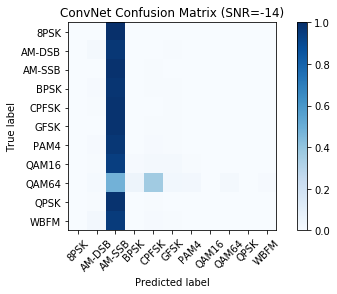

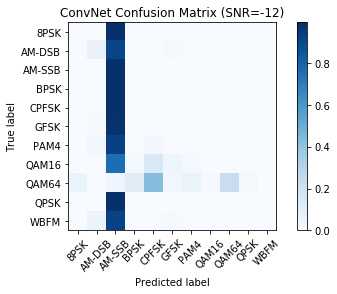

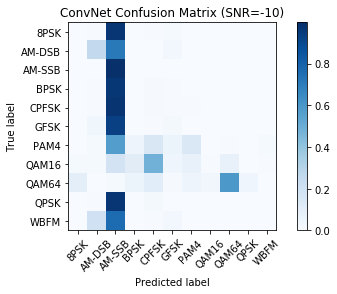

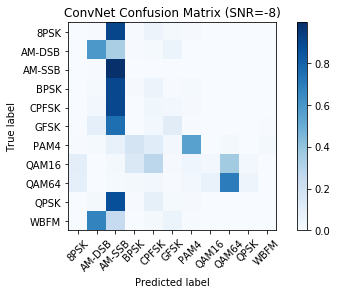

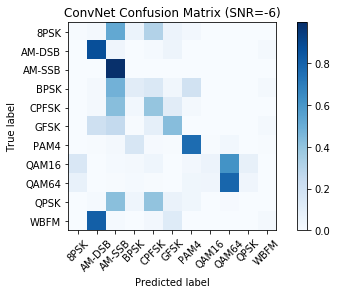

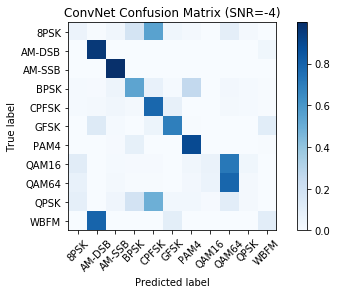

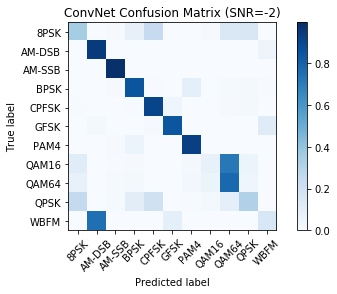

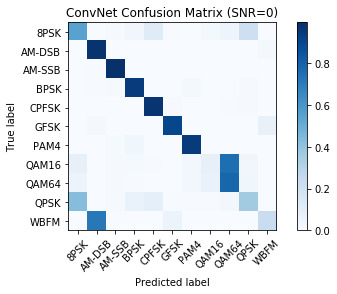

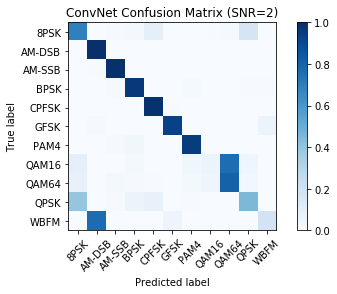

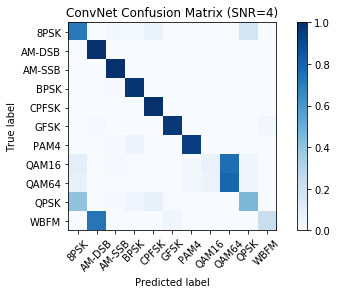

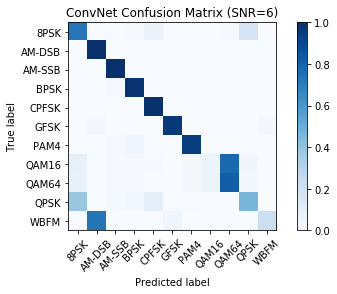

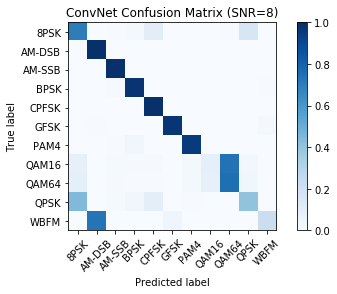

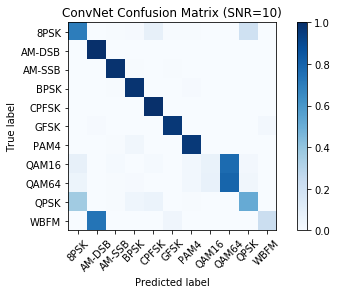

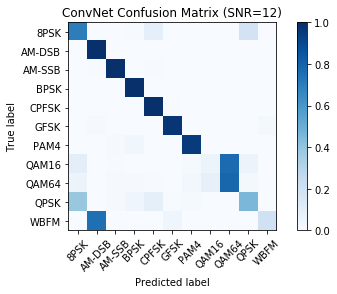

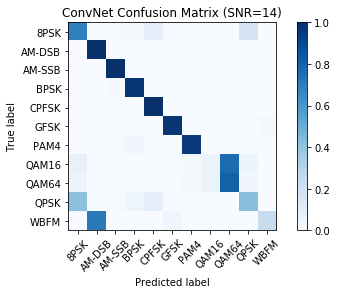

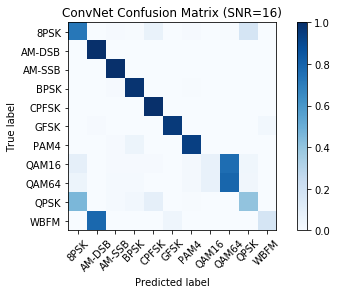

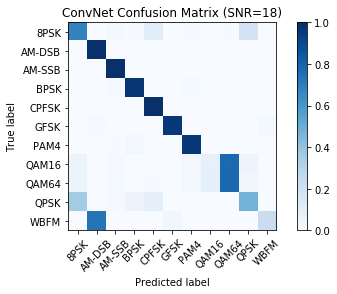

In [25]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

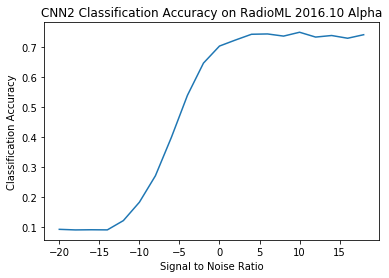

In [26]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

## Compare the size of the pruned and unpruned model after compression

In [12]:
import tempfile
import zipfile
import os

In [9]:
keras_file = "model/RF-CNN-full.h5"

In [10]:
pruned_keras_file = "model/RF-CNN-pruned-0.9.h5"

In [13]:
_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(keras_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(keras_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))

_, zip2 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_keras_file)
print("Size of the pruned model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file) / float(2**20)))
print("Size of the pruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip2) / float(2**20)))

Size of the unpruned model before compression: 5.03 Mb
Size of the unpruned model after compression: 4.35 Mb
Size of the pruned model before compression: 1.69 Mb
Size of the pruned model after compression: 0.33 Mb
